# Bone Abnormality Classification

## Introduction

#### Project Overview

The MURA abnormality detection task is a binary classification task, where the input is an upper
exremity radiograph study — with each study containing one or more views (images) — and the
expected output is a binary label y ∈ {0, 1} indicating whether the study is normal or abnormal,
respectively.

Available X-ray images are of Elbows, fingers, shoulders, forearms, hands, wrists, humerus.


** َQuestions: **
* will we train the model on all limps or will it be trained and evaluated separately on each limp?
* what is Cohen's kappa statistic ? how is it calculated ? how to read its values and compare them ?


#### Problem Statement

We are going to implement a deep convolutional neural networks model that takes a study as input and output the probability of abnormality.

A study consists of one or more images (views) which are feeded one by one into the model to output the probability of abnormality of each one, then the overall probability of a study is the arithmetic mean of all its views.

The model makes the binary prediction of abnormal is the probability of abnormality is greater than 0.5 .

#### Evaluation Metrics

## Analysis

### Data Exploration

#### Dataset download

In [81]:
# -*- coding: utf-8 -*-

In [82]:
#!wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
#!unzip MURA-v1.1.zip
!ls

 dog_app.ipynb				   MURA.ipynb   MURA-v1.1
'Mura Bone Abnormality classifier.ipynb'   MURA.pdf     MURA-v1.1.zip


#### Eyeballing data conclusions:

Dataset is unzipped into 2 folders ("train" and "valid" folders) and 4 csv files

* train folder contains X training set images
* valid folder contains X validation set images
* train_image_paths.csv contains paths to all images in the training set
* train_labeled_studies.csv contains paths to all studies in the training set, and the second column has the label of the study
* labels are 0 for normal and 1 for abnormal
* valid_image_paths.csv and valid_labeled_studies.csv are like training ones
* A study directory contains one or more png images of views of a certain limp, named imagex.png where x is index of image
* images are organized in folders as SET_FOLDER -> LIMP FOLDER -> PATIENT FOLDER -> STUDY FOLDER -> images (views)


MURA contains 9,045 normal and 5,818 abnormal musculoskeletal radiographic studies,14,863 studies from 12,173 patients, with a total of 40,561 multi-view radiographic images according to their paper.

"We split the dataset into training
(11,184 patients, 13,457 studies, 36,808 images), validation (783 patients, 1,199 studies, 3,197 im-
ages), and test (206 patients, 207 studies, 556 images) sets. There is no overlap in patients between
any of the sets."

In train_images CSV and from paper:

Sholder : from 1 to 8379 (8380 images from 1364 normal and 1457 abnormal studies)

Humerus: 8380 to 9651    (1272 images from 321 normal and 271 abnormal studies)

Finger: 9652 to 14757    (5106 images from 1280 normal and 655 abnormal studies)

Elbow: 14578 to 19668    (5091 images from 1094 normal and 660 abnormal studies)

Wrist: 19669 to 29440    (9772 images from 2134 normal and 1326 abnormal studies)

ForeArm: 29441 to 31265  (1825 images from 590 normal and 287 abnormal studies)

Hand: 31266 to 36808     (5543 images from 1497 normal and 521 abnormal studies)

#### Exploratory Visualization

In [83]:
#load boundary images from train_images csv file
# from numpy import genfromtxt
# my_data = genfromtxt('MURA-v1.1/train_image_paths.csv', delimiter=',')
# print(my_data)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
pd.options.display.max_colwidth = 100
df=pd.read_csv('MURA-v1.1/train_image_paths.csv', sep=',',header=None)
print(df.head(5))


                                                                     0
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [84]:
shoulder_paths_train=df[df[0].str.contains("SHOULDER")==True]
humerus_paths_train=df[df[0].str.contains("HUMERUS")==True]
hand_paths_train=df[df[0].str.contains("HAND")==True]
finger_paths_train=df[df[0].str.contains("FINGER")==True]
wrist_paths_train=df[df[0].str.contains("WRIST")==True]
elbow_paths_train=df[df[0].str.contains("ELBOW")==True]
forearm_paths_train=df[df[0].str.contains("FOREARM")==True]

In [85]:
#validating correct division
#display full string in pandas

#Each limp
print("Shoulder first sample and shape:")
shoulder_one=shoulder_paths_train.head(1).to_string(index=False,header=False)
print(shoulder_one )
print(shoulder_paths_train.shape)

print("\nHumerus first sample and shape:")
humerus_one=humerus_paths_train.head(1).to_string(index=False,header=False)
print(humerus_one )
print(humerus_paths_train.shape)

print("\nhand first sample and shape:")
hand_one=hand_paths_train.head(1).to_string(index=False,header=False)
print(hand_one )
print(hand_paths_train.shape)

print("\nfinger first sample and shape:")
finger_one=finger_paths_train.head(1).to_string(index=False,header=False)
print(finger_one )
print(finger_paths_train.shape)

print("\nwrist first sample and shape:")
wrist_one=wrist_paths_train.head(1).to_string(index=False,header=False)
print(wrist_one )
print(wrist_paths_train.shape)

print("\nelbow first sample and shape:")
elbow_one=elbow_paths_train.head(1).to_string(index=False,header=False)
print(elbow_one )
print(elbow_paths_train.shape)

print("\nforearm first sample and shape:")
forearm_one=forearm_paths_train.head(1).to_string(index=False,header=False)
print(forearm_one )
print(forearm_paths_train.shape)


Shoulder first sample and shape:
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
(8379, 1)

Humerus first sample and shape:
MURA-v1.1/train/XR_HUMERUS/patient02695/study1_positive/image1.png
(1272, 1)

hand first sample and shape:
MURA-v1.1/train/XR_HAND/patient09734/study1_positive/image1.png
(5543, 1)

finger first sample and shape:
MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png
(5106, 1)

wrist first sample and shape:
MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image1.png
(9752, 1)

elbow first sample and shape:
MURA-v1.1/train/XR_ELBOW/patient04903/study1_positive/image1.png
(4931, 1)

forearm first sample and shape:
MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image1.png
(1825, 1)


In [86]:
!ls MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/


image1.png  image2.png	image3.png


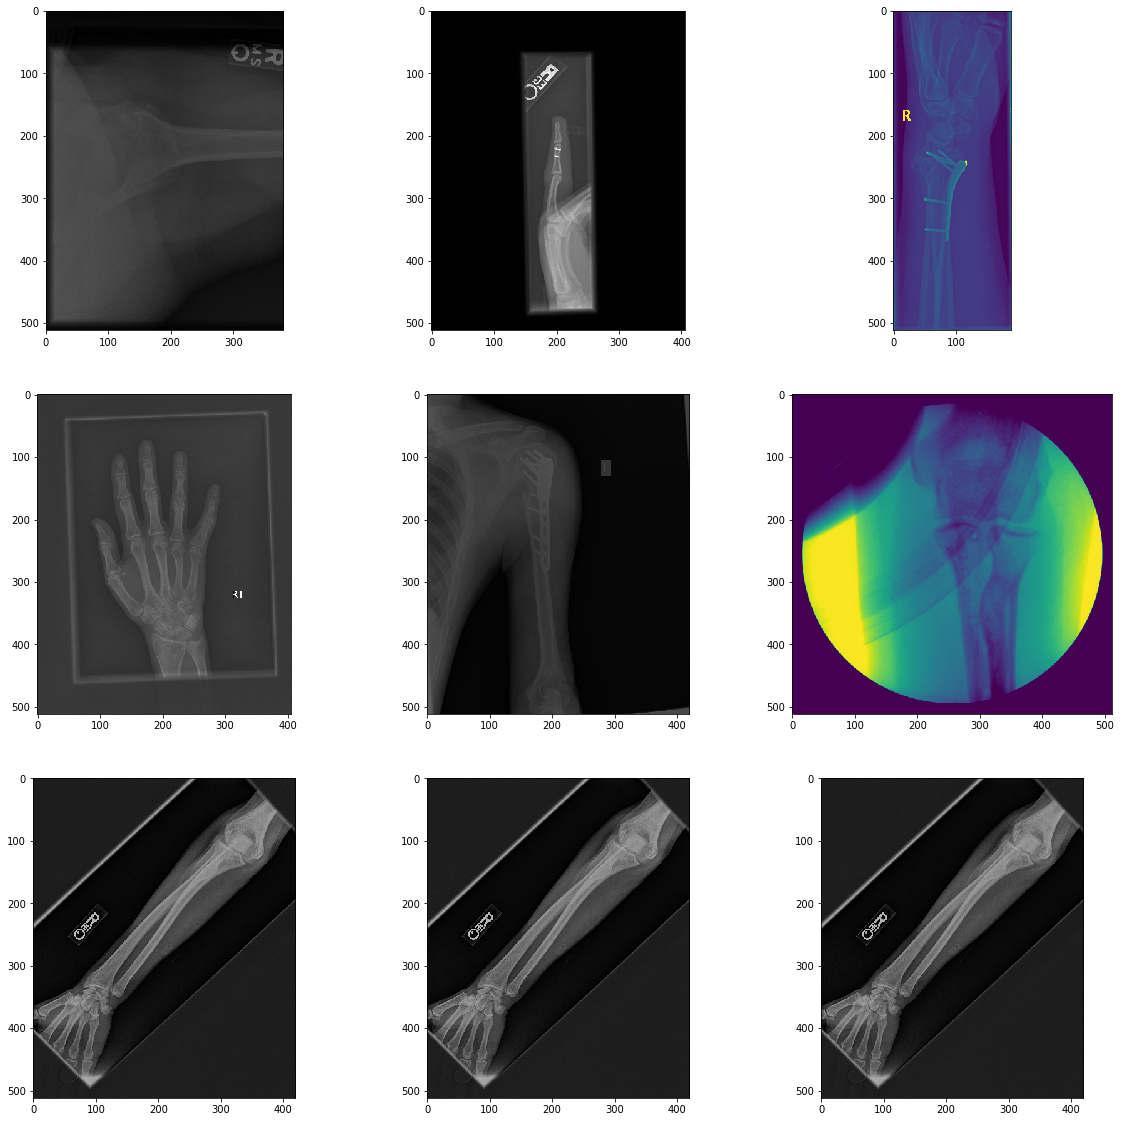

In [87]:
#plotting an image of each limp

paths=np.array([shoulder_one,finger_one,wrist_one,hand_one,humerus_one,elbow_one,forearm_one])

fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
y=0
for i in range(1, columns*rows +1):
    #just because too lazy to make them 9 images instead of 7 xD
    if(y>6):
        y=6
    path=paths[y]
    img=plt.imread(path)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    y+=1
plt.show()

In [88]:
#print(wrist_paths_train[0])

** TODO: continue trying to get labels right for individual images **

In [89]:
# #had to do it non vectorized to be fast
# wrist_labels=np.empty(wrist_paths_train.shape[0])
# wrists=np.array(wrist_paths_train)
# index=0
# for wrist in wrists:
#     if (("positive" in wrist) ):
#         wrist_labels[index]=1
#     else:
#         wrist_labels[index]=0
#     index+=1

# print(wrists[1000:1040])
# print(wrist_labels[1000:1040])

[['MURA-v1.1/train/XR_WRIST/patient06621/study1_positive/image2.png']
 ['MURA-v1.1/train/XR_WRIST/patient06621/study1_positive/image3.png']
 ['MURA-v1.1/train/XR_WRIST/patient06621/study1_positive/image4.png']
 ['MURA-v1.1/train/XR_WRIST/patient06622/study1_positive/image1.png']
 ['MURA-v1.1/train/XR_WRIST/patient06622/study1_positive/image2.png']
 ['MURA-v1.1/train/XR_WRIST/patient06622/study1_positive/image3.png']
 ['MURA-v1.1/train/XR_WRIST/patient06623/study1_positive/image1.png']
 ['MURA-v1.1/train/XR_WRIST/patient06623/study1_positive/image2.png']
 ['MURA-v1.1/train/XR_WRIST/patient06623/study1_positive/image3.png']
 ['MURA-v1.1/train/XR_WRIST/patient06624/study1_positive/image1.png']
 ['MURA-v1.1/train/XR_WRIST/patient06624/study1_positive/image2.png']
 ['MURA-v1.1/train/XR_WRIST/patient06624/study1_positive/image3.png']
 ['MURA-v1.1/train/XR_WRIST/patient06356/study1_positive/image1.png']
 ['MURA-v1.1/train/XR_WRIST/patient06356/study1_positive/image2.png']
 ['MURA-v1.1/train/X

In [90]:
wrists=np.array(wrist_paths_train)
wrists_labels=wrists["positive" in wrists]
print(wrists_labels)

[]


** DOING: loading studies and their labels **

In [91]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
print(studies.head(10))

                                                           0  1
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/  1
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/  1
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/  1
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/  1
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/  1
5  MURA-v1.1/train/XR_SHOULDER/patient00006/study1_positive/  1
6  MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/  1
7  MURA-v1.1/train/XR_SHOULDER/patient00007/study2_negative/  0
8  MURA-v1.1/train/XR_SHOULDER/patient00008/study1_positive/  1
9  MURA-v1.1/train/XR_SHOULDER/patient00009/study1_positive/  1


In [92]:
first=studies.head(2)
# to access path df[0][index], to access label df[1][index], therefore column first then row index
print(first[0][0])

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/


In [93]:
#getting all file names in folder
#!ls MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
onlyfiles = [f for f in listdir("MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/") if isfile(join("MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/", f))]
print(onlyfiles)

['image1.png', 'image3.png', 'image2.png']


In [94]:
#trying getting full paths
x=first[0][0]+onlyfiles[0]
print(x)

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png


In [95]:
print(studies.shape)

(13457, 2)


In [96]:
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
image_paths=[]
image_labels=[]
for i in tqdm( range(studies.shape[0]) ):
    study_path=studies[0][i]
    study_label=studies[1][i]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        image_paths.append(study_path + image)
        image_labels.append(study_label)



100%|██████████| 13457/13457 [00:00<00:00, 19893.78it/s]


In [97]:
image_paths=np.array(image_paths)
image_labels=np.array(image_labels)
print(image_paths[0:25])
print(image_labels[0:25])

['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image3.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image2.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image1.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image4.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image3.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image2.png'
 'MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/image1.png'
 'MURA

In [98]:
print(image_labels.shape)

(36812,)


In [109]:
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
print(wrist_tr.shape)
print(wrist_tr.head(1)[0],"\n",wrist_tr.head(1)[1])

(3460, 2)
7102    MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/
Name: 0, dtype: object 
 7102    1
Name: 1, dtype: int64


In [130]:
wrist_tr=np.array(wrist_tr)
print(wrist_tr[0])
print(wrist_tr[0][0])
print(wrist_tr[1][0])
print(wrist_tr[0][1])
#first bracket is for index (row) and second is for colum

['MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/' 1]
MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/
MURA-v1.1/train/XR_WRIST/patient06360/study1_positive/
1


In [140]:
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths=[]
wrist_labels=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths.append(study_path + image)
        wrist_labels.append(study_label)


100%|██████████| 3460/3460 [00:00<00:00, 38337.84it/s]


In [142]:
wrist_paths=np.array(wrist_paths)
wrist_labels=np.array(wrist_labels)
print(wrist_paths[0:5])
print(wrist_labels[0:5])
print(wrist_paths[9750:9755])
print(wrist_labels[9750:9755])
print(wrist_labels.shape)

['MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image1.png'
 'MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image2.png'
 'MURA-v1.1/train/XR_WRIST/patient06360/study1_positive/image1.png'
 'MURA-v1.1/train/XR_WRIST/patient06360/study1_positive/image4.png'
 'MURA-v1.1/train/XR_WRIST/patient06360/study1_positive/image3.png']
[1 1 1 1 1]
['MURA-v1.1/train/XR_WRIST/patient09081/study1_negative/image1.png'
 'MURA-v1.1/train/XR_WRIST/patient09081/study1_negative/image3.png'
 'MURA-v1.1/train/XR_WRIST/patient09081/study1_negative/image2.png'
 'MURA-v1.1/train/XR_WRIST/patient09082/study1_negative/image1.png'
 'MURA-v1.1/train/XR_WRIST/patient09082/study1_negative/image3.png']
[0 0 0 0 0]
(9756,)


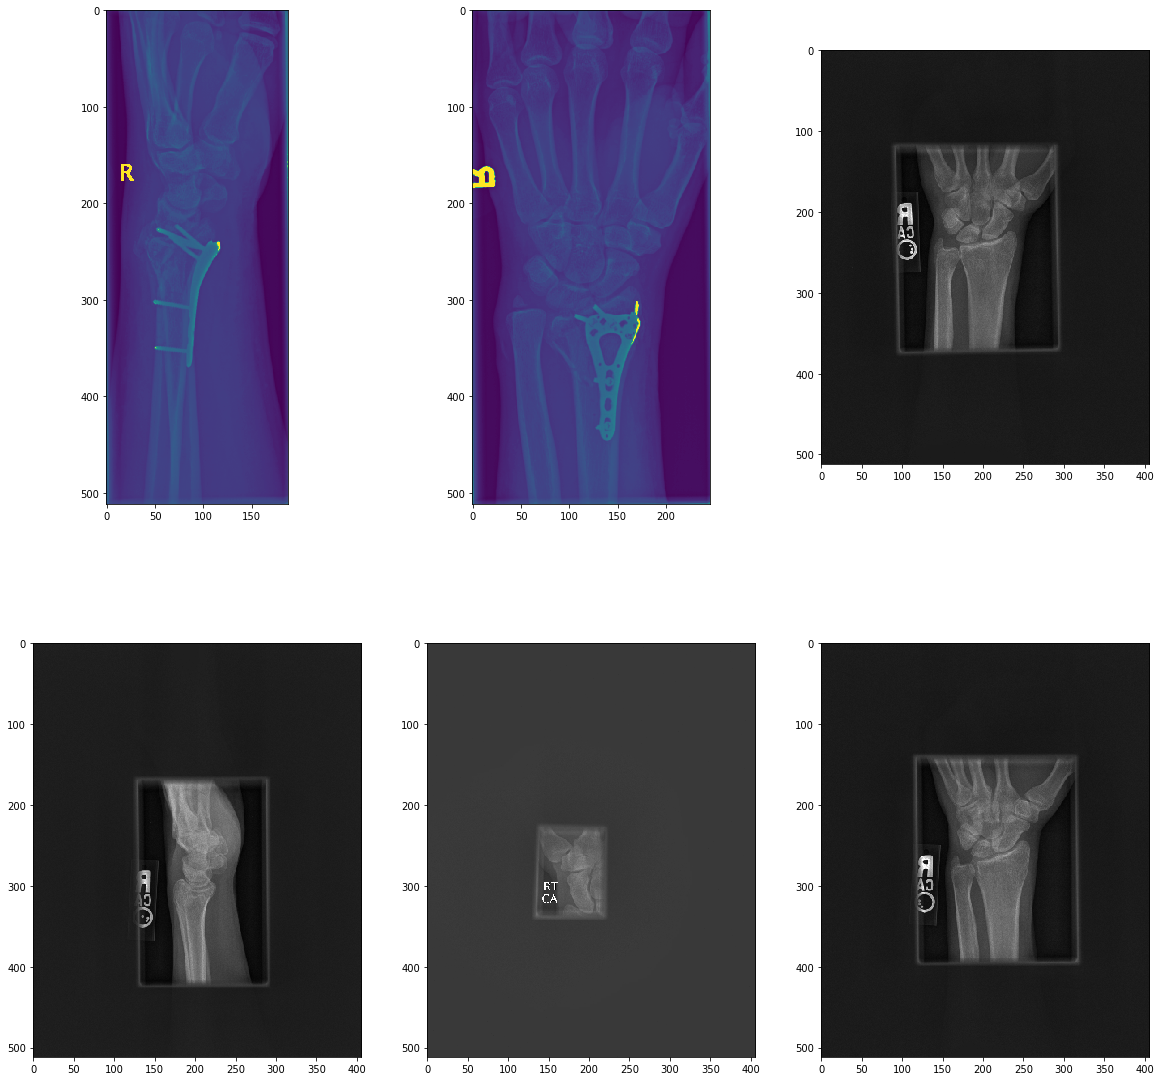

In [144]:
#plotting normal wrists
paths=np.array(wrist_paths[0:6])

fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 2
y=0
for i in range(1, columns*rows +1):
    #just because too lazy to make them 9 images instead of 7 xD
    if(y>6):
        y=6
    path=paths[y]
    img=plt.imread(path)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    y+=1
plt.show()

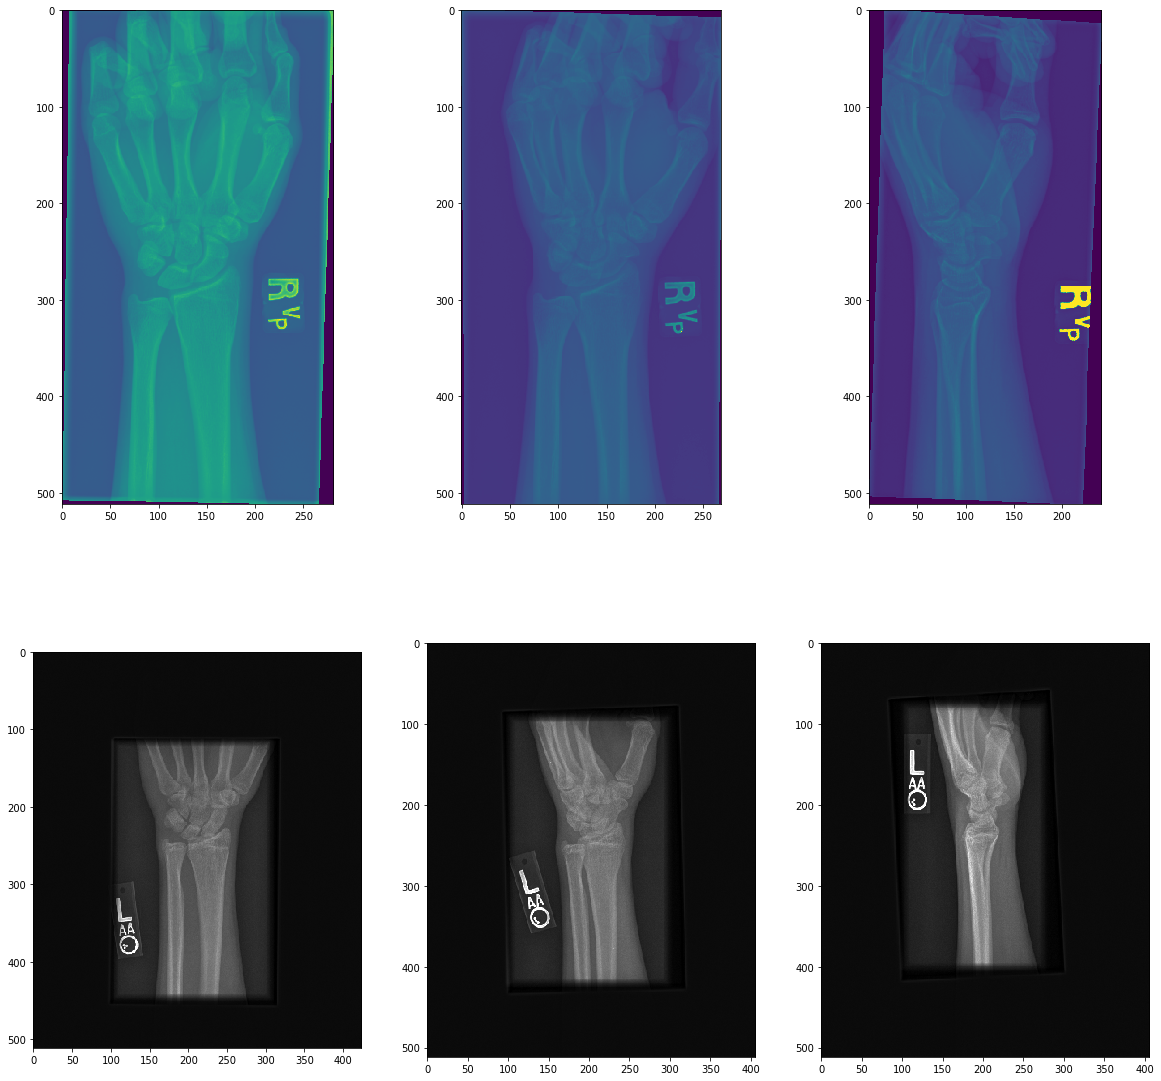

In [145]:
#plotting abnormal wrists
paths=np.array(wrist_paths[9750:9756])

fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 2
y=0
for i in range(1, columns*rows +1):
    #just because too lazy to make them 9 images instead of 7 xD
    if(y>6):
        y=6
    path=paths[y]
    img=plt.imread(path)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    y+=1
plt.show()

#### Benchmark

Random Chance: not 50% because number of normal > number of abnormal , so probability of correctness if normal was chosen is higher

Historical results: only paper results and github implementations

## Methodology

EXPLANATION OF WHOLE METHODOLOGY FLOW BRIEFLY
THEN EACH ONE IN DETAILS BELOW WITH VISUALIZATION OF EACH STEP IF POSSIBLE

** Initial Strategy ** 
PROBABLY GOING TO START WITH WRIST STUDIES ONLY AS A START
Training model

1-For each limp train a separate copy of the model

2-For each study of the limp in labeled studies sheet : 

    i-take all views and subtract mean image (how to get it ? )
    
    ii-then resize images to 320*320 if using densenet or resize it for 
            the used Tranfer Learning model used in network architecture
            
    iii- perform data augmentation (optional)


3-save preprocessed images in a dictionary as values with the key of study index and abnormality labels for the studies should be save in separate numpy array having label corresponding to study index (it may induce memory issues especially if did data augmentation: the RAM may not be able to hold all images therefore it should be done for each limp then overrite the same variables for garbage collection)


4-A single sample in the training set is a whole study with all its views  and therefore the loss will be calculated according to overall score (probability that the study is abnormal which is the arithmetic mean of the probabilities of all views of the study) 
(or should a single sample be a single view from a study and the score be the probability of that single view?)


5- Use a pretrained Transfer Learning model from Keras starting with Densenet that was used in the paper and maybe try another one like inception and use imagenet weights


6- Replace the final fully connected layer with one that has a single output, after which  apply a sigmoid nonlinearity


7- Where will I implement the weigted binary cross entropy loss ?

### Data Preprocessing

** insights ** 
* "Before feeding images into the network, we normalized each image to have the same mean and
standard deviation of images in the ImageNet training set."
* "We then scaled the variable-sized images
to 320 × 320" for densnet probably
* We augmented the data during training by applying random lateral inversions and
rotations of up to 30 degrees.


#### Subtracting mean image

In [ ]:
preprocess_input

#### Resizing images

#### Data Augmentation (optional)

#### Model

** insights ** 
* "The network was trained end-to-end using Adam with default parameters β 1 =
0.9 and β 2 = 0.999"

* "We trained the model using minibatches of size 8. We
used an initial learning rate of 0.0001 that is decayed by a factor of 10 each time the validation loss
plateaus after an epoch. We ensembled the 5 models with the lowest validation losses"

* "We replaced the final fully connected layer with one that
has a single output, after which we applied a sigmoid nonlinearity."

#### Algorithms and techniques

after each step there is a breif description of each Algorithm and Technique used followed by reason of usage.

## Results

** insights **

* overall kappa is the summation of kappa performance over each limp independently
* they have their own weighted and optimized binary cross entropy loss function

## Conclusion